## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

def colorfilter(image, rgb_threshold):
    
    
    color_select = np.copy(image)
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])

    color_select[thresholds] = [0,0,0]
    
    
    return color_select

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    global left_slope, right_slope
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    slope_err = 0.19
    height = img.shape[0]
    width  = img.shape[1]
    
    leftx  = []
    rightx = []
    lefty  = []
    righty = []
    
    if lines != None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                if abs((y2-y1)/(x2-x1)) > 0.5: # Eliminates horizontal lines
                    if (y2-y1)/(x2-x1) < 0:
                        # This line belongs to the left lane
                        # Ignore lines that vary from the previous known slope by
                        # a big margin
                        if (abs((y2-y1)/(x2-x1) - left_slope) < slope_err) or left_slope == 0:
                            leftx.extend([x1, x2])
                            lefty.extend([y1, y2])
                    else:
                        # This line belongs to the right lane
                        # Ignore lines that vary from the previous known slope by
                        # a big margin
                        if (abs((y2-y1)/(x2-x1) - right_slope) < slope_err) or right_slope == 0:
                            rightx.extend([x1, x2])
                            righty.extend([y1, y2])

        # Fit the lines to a polynomial of degree 1 as we are dealing 
        # with straight lines
        if len(leftx) > 0:
            left_lane = np.polyfit(leftx, lefty, 1)
            if (abs(left_lane[0] - left_slope) < slope_err) or left_slope == 0:
                lx1 = int((height - left_lane[1])/left_lane[0])
                lx2 = int((height/1.7 - left_lane[1])/left_lane[0])
                left_slope = left_lane[0]
                cv2.line(img, (lx1, height), (lx2, int(height/1.7)), color, 10)

        if len(rightx) > 0:
            right_lane = np.polyfit(rightx, righty, 1)
            if (abs(right_lane[0] - right_slope) < slope_err) or right_slope == 0:
                lx1 = int((height - right_lane[1])/right_lane[0])
                lx2 = int((height/1.7 - right_lane[1])/right_lane[0])
                right_slope = right_lane[0]
                cv2.line(img, (lx1, height), (lx2, int(height/1.7)), color, 10)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
def process_image(image):
    
    # The following code implements the lane detection pipeline
    
    # Step 1: Retain only white and yellow colors in the image.
    #         This eliminates darker colors like road color and gives
    #         a good chance of detecting lane edges in the frames
    red_th = 150
    green_th = 150
    blue_th = 50
    rgb_threshold = [red_th, green_th, blue_th]
    color_select = colorfilter(image, rgb_threshold)
    #mpimg.imsave("test_images_output/color_select.jpg", color_select)
    
    # Step 2: Convert the color image to gray scale
    gray = grayscale(color_select)
    #mpimg.imsave("test_images_output/gray.jpg", gray, cmap='gray')
    
    # Step3: Smoothen the edges using Gaussian blur
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    #mpimg.imsave("test_images_output/blur_gray.jpg", blur_gray, cmap='gray')
    
    # Step4: Define a region of interest where we are likely to find a lane
    #        and remove everything outside that region
    imshape = image.shape
    height = imshape[0]
    width = imshape[1]
    
    vertices = np.array([[(0,height),(width/2 - 20, height/1.7), \
					(width/2 + 20, height/1.7), (width,height)]], dtype=np.int32)
    roiImage = region_of_interest(blur_gray, vertices)
    #mpimg.imsave("test_images_output/roiImage.jpg", roiImage, cmap='gray')
    
    # Step 5: Detect edges using Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = canny(roiImage, low_threshold, high_threshold)
    #mpimg.imsave("test_images_output/edges.jpg", edges, cmap='gray')
    
    # Step 6: Use Hough transforms to identify straight lines.
    #         These straight lines are likely to be lane edges
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 20 
    line_img = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)
    #mpimg.imsave("test_images_output/hough_lines.jpg", line_img)
    
    #Step 7: Overlay the image with the line on top of the original image
    output_image = weighted_img(line_img, image)
    #mpimg.imsave("test_images_output/output.jpg", output_image)
    
    return output_image

## Testing on images

Let us test the pipeline on the images before applying it on videos

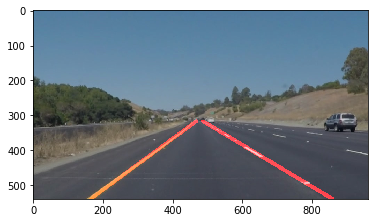

In [6]:
# Testing on images first
left_slope = 0
right_slope = 0
image = mpimg.imread("test_images/solidYellowCurve.jpg")
output_image = process_image(image)
plt.imshow(output_image)
    

## Applying the pipeline on videos

Let's try the one with the solid white lane on the right first ...

In [7]:
left_slope = 0
right_slope = 0
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:09<00:00, 24.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 10.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
left_slope = 0
right_slope = 0
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:29<00:00, 23.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 30.7 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
left_slope = 0
right_slope = 0
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:20<00:00, 10.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 23.1 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))